In [1]:
# Bu hücreyi bir kez çalıştırman yeterli
!pip install -U tensorflow tensorflow-addons scikit-learn pandas matplotlib seaborn plotly opencv-python


ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow-addons


In [2]:
import os, sys, random, math, json, glob, shutil, warnings
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

print("TensorFlow:", tf.__version__)

PROJECT_DIR = Path.cwd()

# DATA_DIR'i otomatik bul (önce data/ships, yoksa data/)
DATA_DIR_CANDIDATES = [PROJECT_DIR / "data" / "ships", PROJECT_DIR / "data"]
DATA_DIR = next((p for p in DATA_DIR_CANDIDATES if p.exists()), None)

# CSV adayları
CSV_CANDIDATES = []
if DATA_DIR:
    CSV_CANDIDATES = [
        DATA_DIR / "train.csv",
        DATA_DIR / "labels.csv",
        DATA_DIR / "train_labels.csv"
    ]
CSV_PATH = next((p for p in CSV_CANDIDATES if p.exists()), None)

# Görsel klasörü adayları
IMG_DIR = None
if DATA_DIR:
    for cand in [DATA_DIR / "images", DATA_DIR / "train", DATA_DIR / "imgs", DATA_DIR]:
        if cand.exists():
            imgs = []
            for pat in ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff","*.JPG","*.JPEG","*.PNG"):
                imgs += list(cand.glob(pat))
            if len(imgs) >= 5:
                IMG_DIR = cand
                break

OUT_DIR = PROJECT_DIR / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

problems = []
if DATA_DIR is None:
    problems.append(f"DATA_DIR yok. Baktığım yerler: {', '.join(str(p) for p in DATA_DIR_CANDIDATES)}")
if CSV_PATH is None:
    problems.append(f"CSV yok. Beklenen: {', '.join(str(p) for p in CSV_CANDIDATES)}")
if IMG_DIR is None:
    looked = []
    if DATA_DIR:
        looked = [DATA_DIR / "images", DATA_DIR / "train", DATA_DIR / "imgs", DATA_DIR]
    problems.append(f"Görsel klasörü yok. Baktığım yerler: {', '.join(str(p) for p in looked)}")
if problems:
    raise FileNotFoundError("\n".join(["YOL/YAPI HATASI:", *problems]))

print(f"DATA_DIR: {DATA_DIR}")
print(f"CSV_PATH: {CSV_PATH}")
print(f"IMG_DIR : {IMG_DIR}")

SEED = 42
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SIZE = 0.2


TensorFlow: 2.20.0
DATA_DIR: C:\Users\berk3\PycharmProjects\GemiSiniflandirmaProjesi\data
CSV_PATH: C:\Users\berk3\PycharmProjects\GemiSiniflandirmaProjesi\data\train.csv
IMG_DIR : C:\Users\berk3\PycharmProjects\GemiSiniflandirmaProjesi\data\images


In [4]:
# Uyarıları temizle (FutureWarning vs.)
# warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv(CSV_PATH)

# Olası sütun isimlerini yakala
cols = {c.lower(): c for c in df.columns}
image_col = next((cols[k] for k in ["image","img","filename","file","name"] if k in cols), None)
label_col = next((cols[k] for k in ["category","label","class","target"] if k in cols), None)

if image_col is None or label_col is None:
    raise KeyError(f"Sütunlar beklenenden farklı. Mevcut: {list(df.columns)} "
                   f"→ görsel (image) ve etiket (category/label) gerekli.")

df[image_col] = df[image_col].astype(str).str.strip()

# Etiket sütunu sayısal değilse güvenli dönüştür (hatalılar NaN olur)
if not pd.api.types.is_numeric_dtype(df[label_col]):
    df[label_col] = pd.to_numeric(df[label_col], errors="coerce")

# 1..5 ise gemi sınıf isimleri:
id_to_name = {1:'Cargo', 2:'Military', 3:'Carrier', 4:'Cruise', 5:'Tanker'}
if pd.api.types.is_integer_dtype(df[label_col]) and df[label_col].dropna().between(1,5).all():
    df["class_name"] = df[label_col].map(id_to_name)
else:
    if df[label_col].dtype == "object":
        df["class_name"] = df[label_col].astype(str)
    else:
        uniq = sorted(pd.Series(df[label_col]).dropna().unique().tolist())
        auto_map = {v: f"class_{i}" for i, v in enumerate(uniq)}
        df["class_name"] = df[label_col].map(auto_map)
        print("Uyarı: Farklı etiket aralığı; otomatik adlar verildi:", auto_map)

# tam dosya yolu
df["filepath"] = df[image_col].apply(lambda x: (IMG_DIR / x).as_posix())

missing = df[~df["filepath"].apply(lambda p: Path(p).exists())]
print("Eksik görsel sayısı:", len(missing))
display(df[[image_col, label_col, "class_name"]].head())
print("Sınıf sayısı:", df["class_name"].nunique())


Eksik görsel sayısı: 0


,image,category,class_name
0,2823080.jpg,1,Cargo
1,2870024.jpg,1,Cargo
2,2662125.jpg,2,Military
3,2900420.jpg,3,Carrier
4,2804883.jpg,2,Military


Sınıf sayısı: 5


In [5]:
# === KATEGORİ KONTROL & DÜZELTME ===
import pandas as pd
from collections import defaultdict

# 1) Tüm unique değerler ve sayıları
print("Kategori değerleri ve sayıları (CSV geneli):")
print(df['category'].value_counts().sort_index())
print("\nSınıf adları ve sayıları (mevcut class_name):")
print(df['class_name'].value_counts())

# 2) Sabit ve doğru id->isim eşlemesi (gemi seti için)
id_to_name = {1:'Cargo', 2:'Military', 3:'Carrier', 4:'Cruise', 5:'Tanker'}

# 3) class_name’i kesin olarak bu eşlemeye göre yeniden ata
df['class_name'] = df['category'].map(id_to_name)

# 4) Eşleme sonrası tutarlılık kontrolü
print("\n(Tekrar) Sınıf adları ve sayıları:")
print(df['class_name'].value_counts())

# 5) Her kategori için küçük bir örnek göster (gözle doğrulama kolay olsun)
import warnings
warnings.filterwarnings("ignore", message=".*DataFrameGroupBy.apply operated on the grouping columns.*")

samples = (
    df.groupby('class_name', group_keys=False)
      .apply(lambda x: x[['image', 'category']].head(3))
      .reset_index(drop=True)
)
display(samples)

# 6) Train/Val split sonrası her sınıf var mı kontrolü
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    df, test_size=VAL_SIZE, random_state=SEED, stratify=df['class_name']
)
print("\nTrain dağılımı:")
print(train_df['class_name'].value_counts().sort_index())
print("\nVal dağılımı:")
print(val_df['class_name'].value_counts().sort_index())


Kategori değerleri ve sayıları (CSV geneli):
category
1    2120
2    1167
3     916
4     832
5    1217
Name: count, dtype: int64

Sınıf adları ve sayıları (mevcut class_name):
class_name
Cargo       2120
Tanker      1217
Military    1167
Carrier      916
Cruise       832
Name: count, dtype: int64

(Tekrar) Sınıf adları ve sayıları:
class_name
Cargo       2120
Tanker      1217
Military    1167
Carrier      916
Cruise       832
Name: count, dtype: int64


,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2833467.jpg,1
3,2900420.jpg,3
4,2859567.jpg,3
5,2847618.jpg,3
6,621252.jpg,4
7,2710618.jpg,4
8,1414706.jpg,4
9,2662125.jpg,2



Train dağılımı:
class_name
Cargo       1696
Carrier      733
Cruise       666
Military     933
Tanker       973
Name: count, dtype: int64

Val dağılımı:
class_name
Cargo       424
Carrier     183
Cruise      166
Military    234
Tanker      244
Name: count, dtype: int64


In [6]:
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df, val_df = train_test_split(
    df,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=df['class_name']
)
print("Train:", len(train_df), Counter(train_df['class_name']))
print("Val  :", len(val_df), Counter(val_df['class_name']))

# DİKKAT: EfficientNet için preprocess_input kullanıyoruz (rescale yok!)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='class_name',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)
val_gen = valid_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='class_name',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

classes_sorted = list(train_gen.class_indices.keys())
num_classes = len(classes_sorted)
print("Sınıflar:", classes_sorted)


Train: 5001 Counter({'Cargo': 1696, 'Tanker': 973, 'Military': 933, 'Carrier': 733, 'Cruise': 666})
Val  : 1251 Counter({'Cargo': 424, 'Tanker': 244, 'Military': 234, 'Carrier': 183, 'Cruise': 166})
Found 5001 validated image filenames belonging to 5 classes.
Found 1251 validated image filenames belonging to 5 classes.
Sınıflar: ['Cargo', 'Carrier', 'Cruise', 'Military', 'Tanker']


In [7]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False  # önce dondur

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)  # preprocess_input zaten generator'da
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
from tensorflow import keras

ckpt_path = (OUT_DIR / "best_efficientnetb0.keras").as_posix()  # .keras uzantısı
callbacks = [
    keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        mode='max',
        restore_best_weights=True
    )
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks
)



Epoch 1/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.6182 - loss: 1.0395
Epoch 1: val_accuracy improved from None to 0.83054, saving model to C:/Users/berk3/PycharmProjects/GemiSiniflandirmaProjesi/outputs/best_efficientnetb0.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 94s 569ms/step - accuracy: 0.7343 - loss: 0.7880 - val_accuracy: 0.8305 - val_loss: 0.5145
Epoch 2/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8315 - loss: 0.4993
Epoch 2: val_accuracy improved from 0.83054 to 0.84972, saving model to C:/Users/berk3/PycharmProjects/GemiSiniflandirmaProjesi/outputs/best_efficientnetb0.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 485ms/step - accuracy: 0.8376 - loss: 0.4806 - val_accuracy: 0.8497 - val_loss: 0.4181
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8479 - loss: 0.4295
Epoch 3: val_accuracy improved from 0.84972 to 0.85612, saving model to C:/Users/berk3/PycharmProjects/GemiSiniflandirmaProjesi/outputs/best_efficientnetb0.keras
157/157 ━━━━━

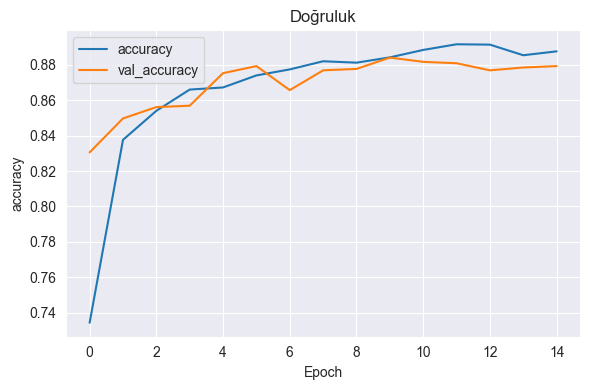

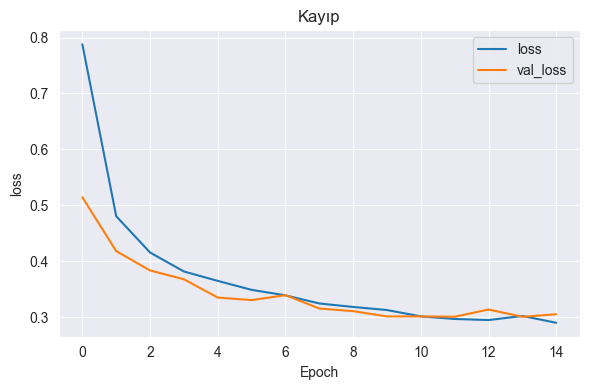

In [9]:
def plot_hist(hist, k, title):
    plt.figure(figsize=(6,4))
    plt.plot(hist.history[k], label=k)
    plt.plot(hist.history['val_'+k], label='val_'+k)
    plt.title(title); plt.xlabel('Epoch'); plt.ylabel(k); plt.legend(); plt.tight_layout()
    plt.show()

plot_hist(history, 'accuracy', 'Doğruluk')
plot_hist(history, 'loss', 'Kayıp')


40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 361ms/step
              precision    recall  f1-score   support

       Cargo     0.8582    0.8420    0.8500       424
     Carrier     0.9780    0.9727    0.9753       183
      Cruise     0.9515    0.9458    0.9486       166
    Military     0.9483    0.9402    0.9442       234
      Tanker     0.7578    0.7951    0.7760       244

    accuracy                         0.8841      1251
   macro avg     0.8988    0.8991    0.8988      1251
weighted avg     0.8854    0.8841    0.8846      1251



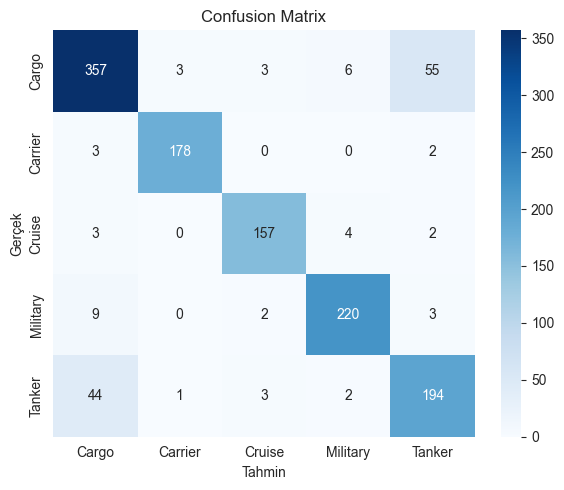

Makro ROC-AUC (OvR): 0.98352478341744
Sınıf bazlı AUC: {'Cargo': 0.9663993520567635, 'Carrier': 0.998869241317206, 'Cruise': 0.9979068347121204, 'Military': 0.9960710653925993, 'Tanker': 0.958377423608511}


In [10]:
# === Değerlendirme (compile=False ile yükle, uyarısız) ===
import warnings
warnings.filterwarnings("ignore")  # gereksiz uyarıları sessize al

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

from tensorflow import keras

# 1) En iyi modeli yükle (optimizer state'i yükleme)
ckpt_path = (OUT_DIR / "best_efficientnetb0.keras").as_posix()  # eğitimde .keras yazmıştık
model = keras.models.load_model(ckpt_path, compile=False)

# 2) Değerlendirme için yeniden derle (optimizer durumuna ihtiyaç yok)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3) Sınıf adları ve indeksleri (generator'dan güvenilir şekilde)
if "classes_sorted" not in globals():
    classes_sorted = list(getattr(train_gen, "class_indices").keys())
name_to_idx = {k: v for k, v in train_gen.class_indices.items()}
num_classes = len(classes_sorted)

# 4) Tahminleri al
val_gen.reset()
pred_probs = model.predict(val_gen, verbose=1)
y_pred = pred_probs.argmax(axis=1)

# 5) Gerçek etiketleri hazırla
y_true = np.array([name_to_idx[n] for n in val_df['class_name'].values])

# 6) Sınıflandırma raporu
report = classification_report(y_true, y_pred, target_names=classes_sorted, digits=4)
print(report)

# Kaydetmek istersen:
(OUT_DIR / "reports").mkdir(exist_ok=True, parents=True)
with open((OUT_DIR / "reports" / "classification_report.txt").as_posix(), "w", encoding="utf-8") as f:
    f.write(report)

# 7) Confusion Matrix (görsel + kayıt)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=classes_sorted, yticklabels=classes_sorted)
plt.xlabel("Tahmin"); plt.ylabel("Gerçek"); plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig((OUT_DIR / "reports" / "confusion_matrix.png").as_posix(), dpi=150)
plt.show()

# 8) ROC-AUC (One-vs-Rest, macro)
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
roc_macro = roc_auc_score(y_true_bin, pred_probs, average='macro', multi_class='ovr')
print("Makro ROC-AUC (OvR):", roc_macro)

# (İsteğe bağlı) tek tek sınıf AUC'lerini yazdırmak için:
try:
    from sklearn.metrics import roc_curve, auc
    class_aucs = {}
    for i, cls in enumerate(classes_sorted):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
        class_aucs[cls] = auc(fpr, tpr)
    print("Sınıf bazlı AUC:", class_aucs)
except Exception:
    pass


In [11]:
# Gövdenin son ~40 katmanını açıp düşük LR ile kısa fine-tune
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 40
for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= fine_tune_at)

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ft_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8825 - loss: 0.3157
Epoch 1: val_accuracy did not improve from 0.88409
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 501ms/step - accuracy: 0.8860 - loss: 0.3036 - val_accuracy: 0.8833 - val_loss: 0.3027
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8907 - loss: 0.3030
Epoch 2: val_accuracy did not improve from 0.88409
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 475ms/step - accuracy: 0.8904 - loss: 0.3024 - val_accuracy: 0.8833 - val_loss: 0.3042
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8957 - loss: 0.2791
Epoch 3: val_accuracy did not improve from 0.88409
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 476ms/step - accuracy: 0.8928 - loss: 0.2920 - val_accuracy: 0.8841 - val_loss: 0.3051
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8958 - loss: 0.2727
Epoch 4: val_accuracy improved from 0.88409 to 0.88489, saving model to C:/Users/berk3/PycharmProjects/GemiSiniflandirmaProjesi/outputs

In [12]:
# Her sınıftan ~10 örnek alın ve küçük sette hızlıca aşırı öğrenebiliyor mu bak
mini = train_df.groupby('class_name').head(10).copy()
mini_gen = train_datagen.flow_from_dataframe(
    mini, x_col='filepath', y_col='class_name',
    target_size=IMG_SIZE, class_mode='categorical',
    batch_size=8, shuffle=True, seed=SEED
)

bm = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
bm.trainable = True
inp = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
xx = bm(inp, training=True)
xx = layers.GlobalAveragePooling2D()(xx)
xx = layers.Dense(256, activation='relu')(xx)
xx = layers.Dropout(0.3)(xx)
out = layers.Dense(num_classes, activation='softmax')(xx)
mini_model = keras.Model(inp, out)
mini_model.compile(optimizer=keras.optimizers.Adam(1e-4),
                   loss='categorical_crossentropy', metrics=['accuracy'])

hist = mini_model.fit(mini_gen, epochs=10, verbose=1)
print("Mini-set son doğruluk:", hist.history['accuracy'][-1])


Found 50 validated image filenames belonging to 5 classes.
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 372ms/step - accuracy: 0.2000 - loss: 1.6654
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 430ms/step - accuracy: 0.3800 - loss: 1.4903
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step - accuracy: 0.5800 - loss: 1.3809
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 0.6200 - loss: 1.2921
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.6800 - loss: 1.1470
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - accuracy: 0.8000 - loss: 1.0205
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.8200 - loss: 0.9125
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.8400 - loss: 0.8511
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.9400 - loss: 0.6666
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.8800 - loss: 0.6848
Mini-set son doğruluk: 0.8799999952316284


In [13]:
final_path = (OUT_DIR / "final_efficientnetb0.keras").as_posix()
model.save(final_path)
with open((OUT_DIR / "class_indices.json").as_posix(), "w", encoding="utf-8") as f:
    json.dump(train_gen.class_indices, f, indent=2, ensure_ascii=False)
print("Kaydedildi:", final_path)


Kaydedildi: C:/Users/berk3/PycharmProjects/GemiSiniflandirmaProjesi/outputs/final_efficientnetb0.keras
